## Necassary Imports

In [1]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

## Data Preprocessing

In [3]:

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        positive="../input/Positive_tensors"
        negative='../input/Negative_tensors'

        positive_file_path= positive + "/"
        negative_file_path= negative + "/"
        positive_files=[positive_file_path + file for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[negative_file_path + file  for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        self.transform = transform
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [4]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


## Model Creation

In [ ]:
model = models.resnet18(pretrained = True)

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
model.fc = nn.Linear(512,2)

### Seeing Model Details

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Defining Loss Function and Optimizer & creating trainloader

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size = 100)

In [14]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


## Training the Model

In [15]:
n_epochs=1
loss_list=[]
accuracy_list=[]
missclassified_samples = {"Y_test": [] ,"Yhat": [], "X_test": []}
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()

start_time = time.time()
for epoch in range(n_epochs):
    COST = 0
    for x, y in train_loader:

        model.train() 
        optimizer.zero_grad()
        z = model(x.view(-1, 3, 224, 224))
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        LOSS = loss.data.item()
        loss_list.append(LOSS)
        COST+=LOSS
       
    correct=0
    for x_test, y_test in validation_loader:
        model.eval()
        z = model(x_test.view(-1, 3, 224, 224))
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y).sum().item()
        missclassified_samples["Y_test"].append(y_test[yhat != y_test])
        missclassified_samples["Yhat"].append(yhat[yhat != y_test])
        missclassified_samples["X_test"].append(x_test[yhat != y_test])
        
        
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
    print("Epoch: ", epoch, "Training Loss: ", COST, "Validation Accuracy: ", accuracy)



Epoch:  0 Training Loss:  23.884727388620377 Validation Accuracy:  0.9943


## Evaulating the Model

In [16]:
print(accuracy)

0.9943

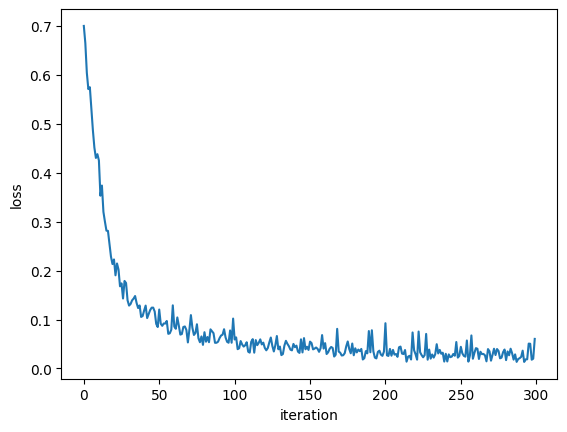

In [17]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [28]:
y_test_misclassified = [item.item() for tensor in missclassified_samples["Y_test"] for item in tensor]
yhat_misclassified = [item.item() for tensor in missclassified_samples["Yhat"] for item in tensor]

In [32]:
for i in range(4):
    print(f"Misclassified Sample {i+1}: Predicted value: {yhat_misclassified[i]}, Actual value: {y_test_misclassified[i]}")
print(f"Total number of misclassified samples out of {N_test}: ", len(yhat_misclassified))

Misclassified Sample 1: Predicted value: 0, Actual value: 1
Misclassified Sample 2: Predicted value: 1, Actual value: 0
Misclassified Sample 3: Predicted value: 0, Actual value: 1
Misclassified Sample 4: Predicted value: 1, Actual value: 0
Total number of misclassified samples out of 10000:  57


In [37]:
missclassified_samples["X_test"][0][0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


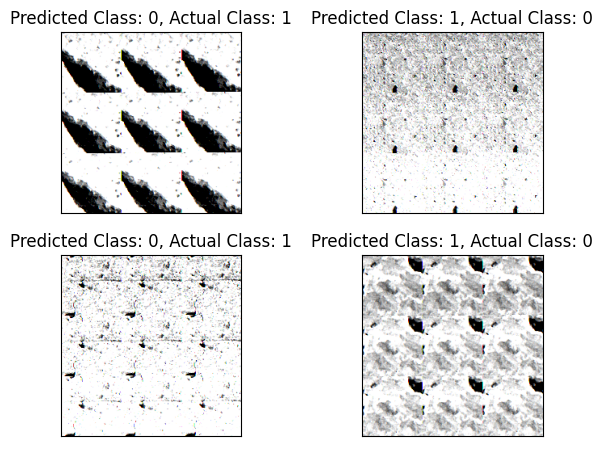

In [47]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(missclassified_samples["X_test"][i][0].reshape(224, 224, 3))
    plt.title(f"Predicted Class: {yhat_misclassified[i]}, Actual Class: {y_test_misclassified[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

## Saving the Model

In [ ]:
# Saving Model
torch.save(model.state_dict(), '../models/model_resnet18.pt')